In [42]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('rcb').getOrCreate()

from pyspark.sql.functions import mean,min,max,col,round,mean,stddev

#### Outliers

Outliers are data points that deviate significantly from the rest of the dataset. These points may lie on either the lower or higher end of the dataset. It is essential to handle outliers before training a model, as they can lead to unpredictable model performance. Outliers can be detected using methods such as the Interquartile Range (IQR) or visualized with a Box Plot

### Using PySpark

In [63]:
data = [(19,),(20,),(30,),(150,),(25,),(15,),(32,)]

df = spark.createDataFrame(data, ['value'])

quantiles = df.approxQuantile("value", [0.25, 0.75],0.0)
IQR = quantiles[1] -  quantiles[0]
lower_bound = quantiles[0] - 1.5 * IQR
upper_bound = quantiles[1] + 1.5 * IQR

min_max = df.select(min('value').alias('min'),max('value').alias('max'),round(mean('value'),2).alias('mean'),round(stddev('value'),2).alias('sd')).collect()[0]

print(f'\033[1mOBSERVATIONS\033[0m\nMinimum Value: {min_max[0]}\nMaximum Value: {min_max[1]}\nMean Value: {min_max[2]}\
       \nStandard Deviation: {min_max[3]}\n1st Quartile: {quantiles[0]}\n3rd Quartile: {quantiles[1]}\nInter Quartile Range: {IQR}\
       \nOutliers Lower Bound: {lower_bound}\nOutliers Upper Bound: {upper_bound}')

def update_outliers():
    out = df.filter((col("value") >= lower_bound) & (col("value") <= upper_bound))
    return [ i['value'] for i in out.collect()]


df = spark.createDataFrame([(x,) for x in update_outliers()], ["value"])
af_remove_outlier = df.select(mean('value').alias('mean_af'),round(stddev('value'),2).alias('sd_af')).collect()[0]

print(f'Mean after removing outerlier: {af_remove_outlier[0]}\nStandard Deviation after removing outlier: {af_remove_outlier[1]}')


update_outliers()

OBSERVATIONS
Minimum Value: 15
Maximum Value: 150
Mean Value: 41.57       
Standard Deviation: 48.2
1st Quartile: 19.0
3rd Quartile: 32.0
Inter Quartile Range: 13.0       
Outliers Lower Bound: -0.5
Outliers Upper Bound: 51.5
Mean after removing outerlier: 23.5
Standard Deviation after removing outlier: 6.66 


[19, 20, 30, 25, 15, 32]

### Using Pandas

In [90]:
import numpy as np
import csv

box_plot = [19,20,30,150,25,15,32]

source = open('source.txt','r')
datas = [int(i.strip()) for i in source.readlines()]
source.close()

min_,Q1,median,Q3,max_= np.quantile(datas,[0,0.25,0.50,0.75,1.0])
series = pd.Series(datas)
mean_value = series.mean().round(2)
stddev_value = series.std().round(2)
IQR = Q3 - Q1
lower_bound = quantiles[0] - 1.5 * IQR
upper_bound = quantiles[1] + 1.5 * IQR

def update_outliers():
    for i in range(0,len(datas)-1):
        if datas[i] < lower_bound or datas[i] > upper_bound:
            del datas[i]
    return datas

with open("non_outlier.txt", "w") as file:
    for item in update_outliers():
        file.write(str(item) + "\n")
        
series = pd.Series(update_outliers())
mean_value_af = series.mean().round(2)
stddev_valu_af = series.std().round(2)
        
print(f'\033[1mOBSERVATIONS\033[0m\nMinimun: {min_}\nMaximum: {max_}\nMedian: {median}\nMean:{mean_value}\nStandard Deviation: {stddev_value}\n1st Quartile: {Q1}\n3rd Quartile: {Q3}\
      \nInter Quartile Range: {IQR}\nOutliers Lower Bound: {lower_bound}\nOutliers Upper Bound: {upper_bound}\
      \nMean after removing outerlier: {mean_value_af}\nStandard Deviation after removing outlier: {stddev_valu_af}' )

update_outliers()


OBSERVATIONS
Minimun: 15.0
Maximum: 150.0
Median: 25.0
Mean:41.57
Standard Deviation: 48.2
1st Quartile: 19.5
3rd Quartile: 31.0      
Inter Quartile Range: 11.5
Outliers Lower Bound: 1.75
Outliers Upper Bound: 49.25      
Mean after removing outerlier: 23.5
Standard Deviation after removing outlier: 6.66


[19, 20, 30, 25, 15, 32]

### Box Plot - before removing outlier

<AxesSubplot:>

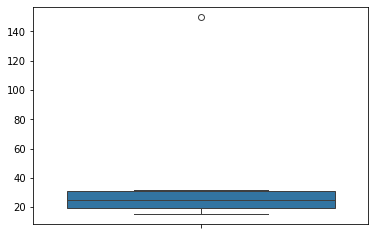

In [41]:
import seaborn as sns

sns.boxplot(box_plot)

### Box Plot - after removing outlier

<AxesSubplot:>

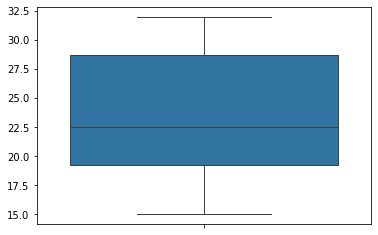

In [40]:
sns.boxplot(datas)